Shape: (3173, 11)
Columns: ['business_id', 'categories', 'state', 'address', 'city', 'name', 'user_id', 'review_id', 'text', 'date', 'stars']


,business_id,categories,state,address,city,name,user_id,review_id,text,date,stars
0,ctHjyadbDQAtUFfkcAFEHw,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",PA,237 St James Pl,Philadelphia,Zahav,XZxMgbZiaXuCTb0l--RoUg,aU8tQnFO-Wdbo325Ax7f1A,date night with girlfriend here was perfect. i...,2014-04-19 12:20:39,5.0
1,ctHjyadbDQAtUFfkcAFEHw,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",PA,237 St James Pl,Philadelphia,Zahav,nkBpODDjnP-nD9uz1Z4YsA,9MFyPkP0wjHMyx18tlF3Pg,Can't say enough good things about Zahav! This...,2015-12-05 15:05:04,5.0
2,ctHjyadbDQAtUFfkcAFEHw,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",PA,237 St James Pl,Philadelphia,Zahav,FC1ZSB9fd4WlDMSAbEjq8Q,939yCAYbEWUwoG8BHyskrQ,"As a foodie, I spend a lot of time researching...",2018-09-14 14:25:32,5.0
3,ctHjyadbDQAtUFfkcAFEHw,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",PA,237 St James Pl,Philadelphia,Zahav,YCIIVcEdGB1MxRH0FfHc3g,Fi-fRDDSrEIppbSC75iYqg,"I think about that Vanessa Carlton line: ""you ...",2014-10-11 14:46:36,5.0
4,ctHjyadbDQAtUFfkcAFEHw,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",PA,237 St James Pl,Philadelphia,Zahav,cR5bvpc0xeQpm-Bsx67A8w,ToTMuvRe_l01iSEMSfxLCA,"Like another reviewer, I had been a bit underw...",2012-02-01 03:44:12,5.0



Feature columns used in hybrid model:
['categories', 'state', 'city', 'name', 'review_length_chars', 'review_length_words', 'text']

Train shape: (2221, 7)
Test shape: (952, 7)
Class distribution in y_train:
 high_rating
1    0.89149
0    0.10851
Name: proportion, dtype: float64

=== Training Hybrid (Numeric + Text) Logistic Regression Model ===

====== HYBRID MODEL RESULTS (NUMERIC + TEXT) ======
Accuracy : 0.924
Precision: 0.956
Recall   : 0.959
F1-score : 0.958

Classification Report:
              precision    recall  f1-score   support

           0      0.657     0.644     0.650       104
           1      0.956     0.959     0.958       848

    accuracy                          0.924       952
   macro avg      0.807     0.801     0.804       952
weighted avg      0.924     0.924     0.924       952

Confusion Matrix:
[[ 67  37]
 [ 35 813]]


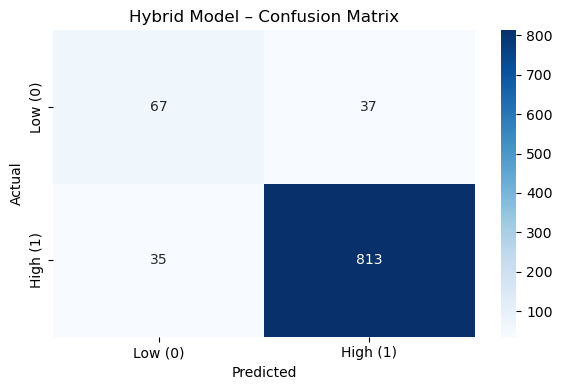

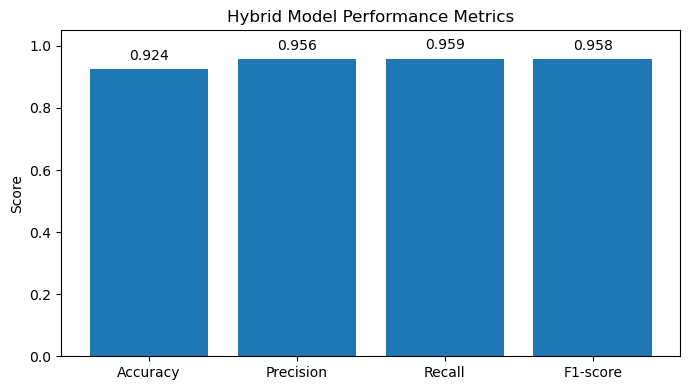

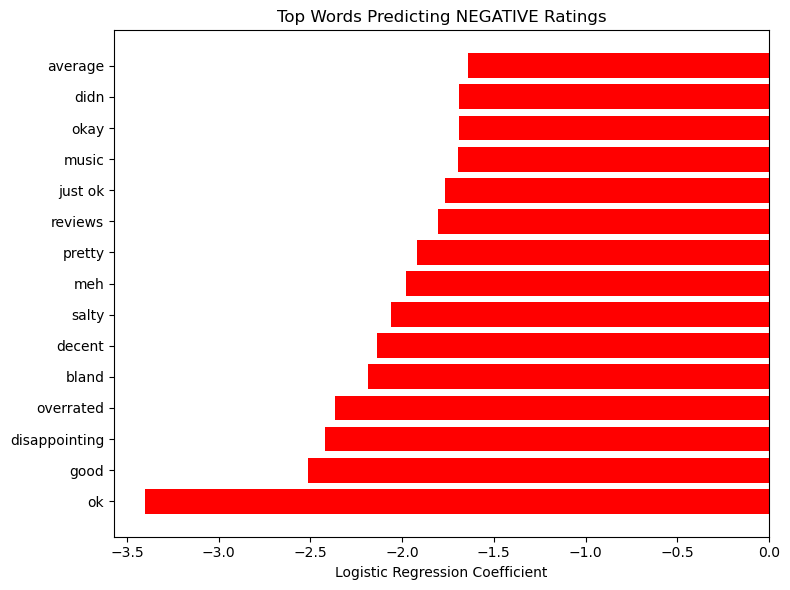

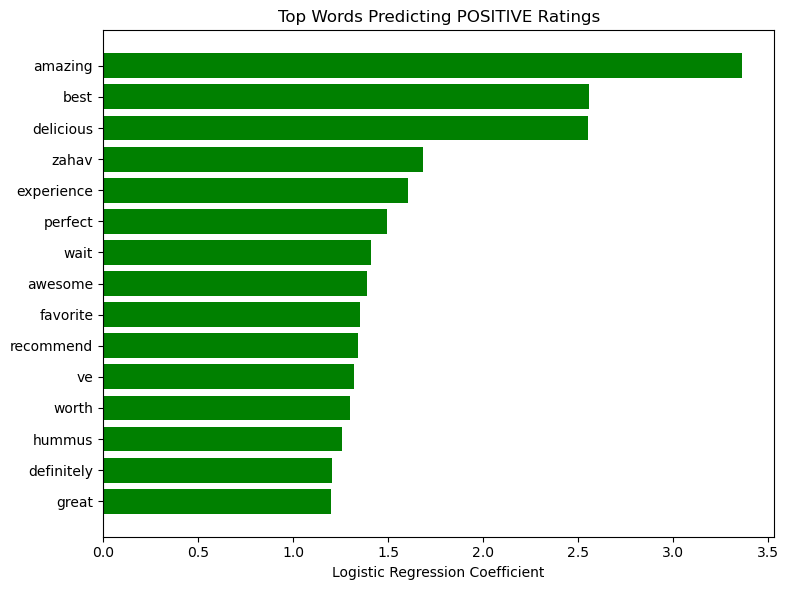

In [ ]:
# ======================================================
# ITM 881 – Capstone Project
# Phase 3: HYBRID MODEL (Numeric + Text)  — Usha
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# ------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------
df = pd.read_csv('/Users/reddyu/Desktop/ITM 881/philadelphia_top_5_Zahav.csv')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# ------------------------------------------------------
# 2. CREATE TARGET: high vs low rating
#    1 = high (stars >= 4), 0 = low (stars < 4)
# ------------------------------------------------------
df["high_rating"] = (df["stars"] >= 4).astype(int)

# ------------------------------------------------------
# 3. ENGINEER SIMPLE NUMERIC FEATURES FROM TEXT
# ------------------------------------------------------
df["review_length_chars"] = df["text"].astype(str).str.len()
df["review_length_words"] = df["text"].astype(str).str.split().str.len()

# ------------------------------------------------------
# 4. DEFINE FEATURES FOR HYBRID MODEL
# ------------------------------------------------------
categorical_cols = ["categories", "state", "city", "name"]
numeric_cols = ["review_length_chars", "review_length_words"]
text_col = "text"

X = df[categorical_cols + numeric_cols + [text_col]].copy()
y = df["high_rating"].copy()

print("\nFeature columns used in hybrid model:")
print(categorical_cols + numeric_cols + [text_col])

# ------------------------------------------------------
# 5. TRAIN / TEST SPLIT
# ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Class distribution in y_train:\n", y_train.value_counts(normalize=True))

# ------------------------------------------------------
# 6. PREPROCESSING PIPELINE
# ------------------------------------------------------
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()
text_transformer = TfidfVectorizer(
    max_features=10000,
    stop_words="english",
    ngram_range=(1, 2)  # unigrams + bigrams
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols),
        ("text", text_transformer, text_col)
    ]
)

# ------------------------------------------------------
# 7. HYBRID MODEL: LOGISTIC REGRESSION
# ------------------------------------------------------
hybrid_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

print("\n=== Training Hybrid (Numeric + Text) Logistic Regression Model ===")
hybrid_clf.fit(X_train, y_train)

# ------------------------------------------------------
# 8. EVALUATION
# ------------------------------------------------------
y_pred = hybrid_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\n====== HYBRID MODEL RESULTS (NUMERIC + TEXT) ======")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# ------------------------------------------------------
# 9. VISUALIZATION: CONFUSION MATRIX HEATMAP
# ------------------------------------------------------
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low (0)', 'High (1)'],
            yticklabels=['Low (0)', 'High (1)'])
plt.title("Hybrid Model – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 10. VISUALIZATION: METRIC BAR CHART
# ------------------------------------------------------
metrics = ['Accuracy','Precision','Recall','F1-score']
values = [acc, prec, rec, f1]

plt.figure(figsize=(7,4))
bars = plt.bar(metrics, values)
plt.ylim(0, 1.05)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}",
             ha='center', va='bottom')

plt.title("Hybrid Model Performance Metrics")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 11. ANALYSIS: WHICH WORDS SIGNAL NEGATIVE REVIEWS?
#     (Top features associated with low ratings)
# ------------------------------------------------------
# Pull out inner pieces
pre = hybrid_clf.named_steps["preprocess"]
model = hybrid_clf.named_steps["model"]

cat_encoder = pre.named_transformers_["cat"]
tfidf = pre.named_transformers_["text"]

cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
num_feature_names = np.array(numeric_cols)
text_feature_names = tfidf.get_feature_names_out()

n_cat = len(cat_feature_names)
n_num = len(num_feature_names)
n_text = len(text_feature_names)

coefs_all = model.coef_[0]

# Indices for each block in the concatenated feature space
cat_coefs = coefs_all[:n_cat]
num_coefs = coefs_all[n_cat:n_cat + n_num]
text_coefs = coefs_all[n_cat + n_num : n_cat + n_num + n_text]

# ----- Top words for NEGATIVE reviews (class 0 has smaller coefficient) -----
top_neg_idx = np.argsort(text_coefs)[:15]
top_neg_words = text_feature_names[top_neg_idx]
top_neg_values = text_coefs[top_neg_idx]

plt.figure(figsize=(8,6))
plt.barh(top_neg_words, top_neg_values, color='red')
plt.title("Top Words Predicting NEGATIVE Ratings")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

# ----- (Optional) Top words for POSITIVE reviews -----
top_pos_idx = np.argsort(text_coefs)[-15:]
top_pos_words = text_feature_names[top_pos_idx]
top_pos_values = text_coefs[top_pos_idx]

plt.figure(figsize=(8,6))
plt.barh(top_pos_words, top_pos_values, color='green')
plt.title("Top Words Predicting POSITIVE Ratings")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()
